In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import glob
from pyds9 import *

# Astropy Packages
import astropy.io.fits as pf
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

from photutils import (detect_sources, detect_threshold, find_peaks, detection, morphology, 
                       CircularAperture, CircularAnnulus)


#-----------------------------------------------------------------------------------------
'''

pyCandClick: a Python implementation of Rob De Rosa's IDL cand_click.pro routine to measure fluxes for multiple stars in a FITS image and estimate their magnitude differences. Also includes automated source detection and centroiding from the photutils package.

Dependencies include the following (some can be installed via pip):
- AstroPy library, including photutils: http://www.astropy.org/
- SAO ds9: http://ds9.si.edu/site/Home.html
- pyds9: https://github.com/ericmandel/pyds9

To run, use the following command: 
python pyCandClick.py

(v1) 12/17/2015 - K. Ward-Duong: Created script.

'''
#-----------------------------------------------------------------------------------------

In [12]:
#-----------------------------------------------------------------------------------------
# Define variables here:

# observing params
platescale = 0.02 # arcsec/px
wavelength = 2.23E-6 # meters; make this more intelligent to grab filter from FITS header
diameter = 6.5 # meters
fwhm = (1.22*wavelength/diameter*206265)/platescale # arcsec converted into pixels

# centroiding and photometry params
boxsize = 10.0/2 # size of subimage to extract centroid (be careful if close companion)
aper_rad = 2.5*fwhm # size in pixels of aperture
sky_annulus_width = 10.0 # in pixels



In [13]:
#-----------------------------------------------------------------------------------------
# Define functions here:

# Automatically identify stars
def starfinder(data):
    # Detect the source peaks at a 3-sigma level and put into table (tbl):
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    threshold = median + (3.0 * std)
    tbl = find_peaks(data, threshold)
    return tbl

# Get user input to select the brightest (primary) star:
def onclick(event):
    if event.xdata != None and event.ydata != None:
        print(event.xdata, event.ydata)
        return event.xdata, event.ydata
        
# Alternative method: key press? doesn't seem to work        
def on_key(event, arg1, arg2, arg3):
    if event.xdata != None and event.ydata != None:
        print('you pressed', event.key, event.xdata, event.ydata)
        
def getphot(positions, radius, skyin, skyout, data):
    apertures = CircularAperture(positions, r = radius)
    #phot_table = aperture_photometry(data, apertures)
    annulus_apertures = CircularAnnulus(positions, r_in = skyin, r_out = skyout)
    
def starfinder_iraf():
    detection.irafstarfind(data, threshold, fwhm, minsep_fwhm=0.5, sky=None, exclude_border=False)
    return # do nothing function...





#-----------------------------------------------------------------------------------------

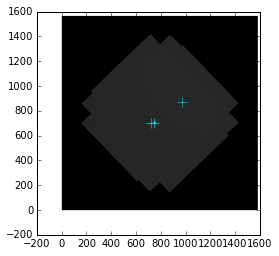

In [15]:
# Get all of the FITS files in the directory of your choice:
files = glob.glob('/Users/Kim/Research/ExoplanetHostProject/mm_final_reduction/HAT-P-39/*.fits')

# Open a ds9 window and set the frame
#d = DS9()
#d.set('frame 1')
    
# Loop over each of the FITS files:
for ii in xrange(0, len(files)): 
    name = files[ii]
    
    # Get the data and header from the ii'th FITS file
    data, header = pf.getdata(name, header = True)
    star_positions = starfinder(data)
    
    # Display to ensure appropriate stars are found
    plt.clf(), plt.cla() # clear any previous figures and axes
    ax, fig = plt.gca(), plt.gcf()
    norm = ImageNormalize(stretch=SqrtStretch()) # normalize image stretch
    
    #implot = ax.imshow(data, cmap='Greys_r', origin='lower', norm=ImageNormalize(stretch=SqrtStretch())) # normalize image stretch when loading data
    plt.imshow(data, cmap='Greys_r', origin='lower', norm=ImageNormalize(stretch=SqrtStretch())) # normalize image stretch when loading data
    plt.plot(star_positions[:,1], star_positions[:,0], ls='none', color='cyan', marker='+', ms=10, lw=1.5) # plot peaks, note swapped x/y!
    
    # For each star, extract a subimage around peak value, centroid in that box, 
    # show the image and centroid, then return the global image coordinates:
    centxpos = []
    centypos = []
    numstars = len(star_positions)
    for jj in xrange(0, numstars):
        xpeak = star_positions[:,1][jj]
        ypeak = star_positions[:,0][jj]
        centroid = morphology.centroid_2dg(data[(ypeak-boxsize):(ypeak+boxsize), (xpeak-boxsize):(xpeak+boxsize)])
        plt.clf(), plt.cla()
        pylab.imshow(data[(ypeak-boxsize):(ypeak+boxsize), (xpeak-boxsize):(xpeak+boxsize)])
        plt.plot(centroid[1], centroid[0], color='white', marker = '+', ms=10)
        plt.show()
        centxpos.append((xpeak - boxsize) + centroid[1])
        centypos.append((ypeak - boxsize) + centroid[0])
    
    # Display to ensure centroid coordinates in full frame are correct:
    plt.clf(), plt.cla() # clear any previous figures and axes    
    plt.imshow(data, cmap='Greys_r', origin='lower', norm=ImageNormalize(stretch=SqrtStretch())) # normalize image stretch when loading data
    plt.plot(centxpos, centypos, ls='none', color='lime', marker='+', ms=10, lw=1.5) # plot *centroids*
    
    # zip together the x and y positions into a new data structure
    cent_positions = zip(centxpos, centypos)
    
    # Extract photometry for each source:
    for kk in xrange(0, numstars):
        
    
    # Get user input to select the brightest (primary) star:
    #print "Click to select the primary star: "
    #cid = fig.canvas.mpl_connect('button_press_event', onclick)
    #cid = fig.canvas.mpl_connect('key_press_event', lambda event: on_key(event, plt1, plt2, plt3))
    #x = pylab.ginput(2)
    #pylab.imshow(x)
    plt.show()
    